# Import necessary libraries

In [169]:
import random
import os

import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.neural_network import MLPRegressor
from sklearn.manifold import TSNE

# PyTorch library
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision.utils import make_grid


import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

# Read data

In [2]:
test = pd.read_csv("data/test.csv")
train = pd.read_csv("data/train.csv")
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


# Check missing values

In [3]:
print('Train')
print(train.isnull().sum())
print('==========================')
print('Test')
print(test.isnull().sum())

Train
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64
Test
PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64


# Fill missing 'Cabin', 'Embarked' and 'Fare' features

In [4]:
train = train.fillna({'Age': -0.1})
test = test.fillna({'Age': -0.1})

#encode sex
train['Sex'] = LabelEncoder().fit_transform(train['Sex'])
test['Sex'] = LabelEncoder().fit_transform(test['Sex'])


#encode cabin
train.loc[~train.Cabin.isnull(), 'Cabin'] = 1
train.loc[train.Cabin.isnull(), 'Cabin'] = 0

test.loc[~test.Cabin.isnull(), 'Cabin'] = 1
test.loc[test.Cabin.isnull(), 'Cabin'] = 0


# detect wich is a most common embarking place and fill missed 'Embarked' values with max embarked places
common_embarked = train.groupby(['Embarked'])['Embarked'].value_counts().idxmax()[0]
train = train.fillna({'Embarked': common_embarked})
test = test.fillna({'Embarked': common_embarked})

# fill 'Fare' null values in test
test.loc[test.Fare.isnull(), 'Fare'] = 0

# Create new feature: 'Title' derived from 'Name'

In [5]:
train['Title'] = train.Name.str.split(',', n=1, expand=True)[1].str.split('.',n=1, expand=True)[0]
train['Title'] = train.Title.str.strip()

test['Title'] = test.Name.str.split(',', n=1, expand=True)[1].str.split('.', n=1, expand=True)[0]
test['Title'] = test.Title.str.strip()

train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,1,0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,A/5 21171,7.2500,0,S,Mr
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,PC 17599,71.2833,1,C,Mrs
2,3,1,3,"Heikkinen, Miss. Laina",0,26.0,0,0,STON/O2. 3101282,7.9250,0,S,Miss
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,1,0,113803,53.1000,1,S,Mrs
4,5,0,3,"Allen, Mr. William Henry",1,35.0,0,0,373450,8.0500,0,S,Mr


In [6]:
train.loc[train.Title == 'Ms', 'Title'] = 'Miss'
test.loc[test.Title == 'Ms', 'Title'] = 'Miss'

train.loc[~train.Title.isin(['Mr', 'Miss', 'Mrs', 'Master']), 'Title'] = 'Other'
test.loc[~test.Title.isin(['Mr', 'Miss', 'Mrs', 'Master']), 'Title'] = 'Other'

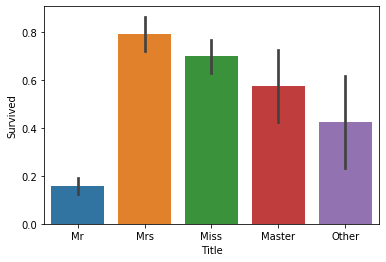

In [7]:
sns.barplot(x='Title', y='Survived', data=train)

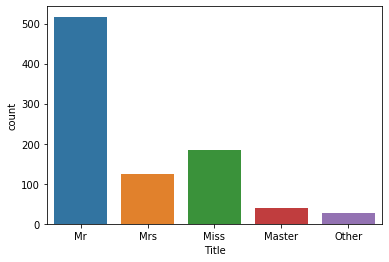

In [8]:
sns.countplot(train.Title)

# Process 'Ticket' feature

It seems that ticket numbers are different from each other by it's prefix. Let's see the connection between this prefixes and 'Survived' feature

In [9]:
train['TicketPrefix'] = train.Ticket.str.split(' ').apply(lambda x: x[0] if len(x) > 1 else 'No')
test['TicketPrefix'] = test.Ticket.str.split(' ').apply(lambda x: x[0] if len(x) > 1 else 'No')
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,TicketPrefix
0,1,0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,A/5 21171,7.2500,0,S,Mr,A/5
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,PC 17599,71.2833,1,C,Mrs,PC
2,3,1,3,"Heikkinen, Miss. Laina",0,26.0,0,0,STON/O2. 3101282,7.9250,0,S,Miss,STON/O2.
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,1,0,113803,53.1000,1,S,Mrs,No
4,5,0,3,"Allen, Mr. William Henry",1,35.0,0,0,373450,8.0500,0,S,Mr,No


In [10]:
train.groupby(['TicketPrefix'])['TicketPrefix'].count()

TicketPrefix
A./5.           2
A.5.            2
A/4             3
A/4.            3
A/5            10
A/5.            7
A/S             1
A4.             1
C               5
C.A.           27
C.A./SOTON      1
CA              6
CA.             8
F.C.            1
F.C.C.          5
Fa              1
No            665
P/PP            2
PC             60
PP              3
S.C./A.4.       1
S.C./PARIS      2
S.O./P.P.       3
S.O.C.          5
S.O.P.          1
S.P.            1
S.W./PP         1
SC              1
SC/AH           3
SC/PARIS        5
SC/Paris        4
SCO/W           1
SO/C            1
SOTON/O.Q.      8
SOTON/O2        2
SOTON/OQ        7
STON/O         12
STON/O2.        6
SW/PP           1
W./C.           9
W.E.P.          1
W/C             1
WE/P            2
Name: TicketPrefix, dtype: int64

In [11]:
train.loc[train.TicketPrefix.str.startswith('A'), 'TicketPrefix'] = 'A'
train.loc[train.TicketPrefix.str.startswith('C'), 'TicketPrefix'] = 'C'
train.loc[train.TicketPrefix.str.startswith('F'), 'TicketPrefix'] = 'F'
train.loc[train.TicketPrefix.str.startswith('P'), 'TicketPrefix'] = 'P'
train.loc[train.TicketPrefix.str.startswith('S'), 'TicketPrefix'] = 'S'
train.loc[train.TicketPrefix.str.startswith('W'), 'TicketPrefix'] = 'W'

test.loc[test.TicketPrefix.str.startswith('A'), 'TicketPrefix'] = 'A'
test.loc[test.TicketPrefix.str.startswith('C'), 'TicketPrefix'] = 'C'
test.loc[test.TicketPrefix.str.startswith('F'), 'TicketPrefix'] = 'F'
test.loc[test.TicketPrefix.str.startswith('P'), 'TicketPrefix'] = 'P'
test.loc[test.TicketPrefix.str.startswith('S'), 'TicketPrefix'] = 'S'
test.loc[test.TicketPrefix.str.startswith('W'), 'TicketPrefix'] = 'W'

train.groupby(['TicketPrefix'])['TicketPrefix'].count()


TicketPrefix
A      29
C      47
F       7
No    665
P      65
S      65
W      13
Name: TicketPrefix, dtype: int64

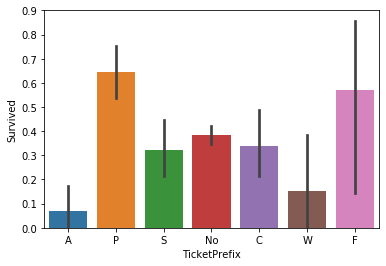

In [12]:
sns.barplot(x='TicketPrefix', y='Survived', data=train)

Let's combine 'Parch' and 'SibSp' feature and create new feature 'Alone'

In [13]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,TicketPrefix
0,1,0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,A/5 21171,7.2500,0,S,Mr,A
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,PC 17599,71.2833,1,C,Mrs,P
2,3,1,3,"Heikkinen, Miss. Laina",0,26.0,0,0,STON/O2. 3101282,7.9250,0,S,Miss,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,1,0,113803,53.1000,1,S,Mrs,No
4,5,0,3,"Allen, Mr. William Henry",1,35.0,0,0,373450,8.0500,0,S,Mr,No


# Encode 'TicketPrefix' feature

In [14]:
train.TicketPrefix.unique()

array(['A', 'P', 'S', 'No', 'C', 'W', 'F'], dtype=object)

In [15]:
def encode_ticket(t):
    e = {
        'No': 0,
        'A': 1,
        'P': 2,
        'S': 3,
        'C': 4,
        'W': 5,
        'F': 6
    }
    return e.get(t, -1)

train['Ticket'] = train.TicketPrefix.apply(encode_ticket)
test['Ticket'] = test.TicketPrefix.apply(encode_ticket)
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,TicketPrefix
0,1,0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,1,7.2500,0,S,Mr,A
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,2,71.2833,1,C,Mrs,P
2,3,1,3,"Heikkinen, Miss. Laina",0,26.0,0,0,3,7.9250,0,S,Miss,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,1,0,0,53.1000,1,S,Mrs,No
4,5,0,3,"Allen, Mr. William Henry",1,35.0,0,0,0,8.0500,0,S,Mr,No


# Encode 'Title' feature

In [16]:
train.Title = LabelEncoder().fit_transform(train.Title)
test.Title = LabelEncoder().fit_transform(test.Title)
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,TicketPrefix
0,1,0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,1,7.2500,0,S,2,A
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,2,71.2833,1,C,3,P
2,3,1,3,"Heikkinen, Miss. Laina",0,26.0,0,0,3,7.9250,0,S,1,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,1,0,0,53.1000,1,S,3,No
4,5,0,3,"Allen, Mr. William Henry",1,35.0,0,0,0,8.0500,0,S,2,No


# Encode 'Embarked' feature

In [17]:
train.Embarked = LabelEncoder().fit_transform(train.Embarked)
test.Embarked = LabelEncoder().fit_transform(test.Embarked)
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,TicketPrefix
0,1,0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,1,7.2500,0,2,2,A
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,2,71.2833,1,0,3,P
2,3,1,3,"Heikkinen, Miss. Laina",0,26.0,0,0,3,7.9250,0,2,1,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,1,0,0,53.1000,1,2,3,No
4,5,0,3,"Allen, Mr. William Henry",1,35.0,0,0,0,8.0500,0,2,2,No


In [18]:
train.drop(['TicketPrefix', 'Name'], axis=1, inplace=True)
test.drop(['TicketPrefix', 'Name'], axis=1, inplace=True)
train.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,1,0,3,1,22.0,1,0,1,7.2500,0,2,2
1,2,1,1,0,38.0,1,0,2,71.2833,1,0,3
2,3,1,3,0,26.0,0,0,3,7.9250,0,2,1
3,4,1,1,0,35.0,1,0,0,53.1000,1,2,3
4,5,0,3,1,35.0,0,0,0,8.0500,0,2,2


# Predict missing 'Ages'

In [19]:
# combine data
data = pd.concat([train, test])
data.drop(['Survived', 'PassengerId'], axis=1, inplace=True)
data.head()

,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,3,1,22.0,1,0,1,7.2500,0,2,2
1,1,0,38.0,1,0,2,71.2833,1,0,3
2,3,0,26.0,0,0,3,7.9250,0,2,1
3,1,0,35.0,1,0,0,53.1000,1,2,3
4,3,1,35.0,0,0,0,8.0500,0,2,2


In [20]:
predictors = data[data.Age > 0]
predictors.drop(['Age'], axis=1, inplace=True)
targets = np.array(data[data.Age > 0].Age)
predictors.shape, targets.shape

((1046, 9), (1046,))

In [21]:
predictors.head()

,Pclass,Sex,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,3,1,1,0,1,7.2500,0,2,2
1,1,0,1,0,2,71.2833,1,0,3
2,3,0,0,0,3,7.9250,0,2,1
3,1,0,1,0,0,53.1000,1,2,3
4,3,1,0,0,0,8.0500,0,2,2


In [22]:
predictors = StandardScaler().fit_transform(predictors)

In [23]:
def seed_everything(seed=1234):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

In [192]:
BATCH_SIZE = 20
EPOCHS = 50
MAX_ITER = 10000


In [142]:
class NNRegressor(nn.Module):
    def __init__(self, inp_size: int, hidden_size: int, out_size: int):
        super().__init__()
        
        
        self.fc1 = nn.Sequential(nn.Linear(inp_size, hidden_size),
                                 nn.ReLU(),
                                 nn.Linear(hidden_size, hidden_size),
                                 nn.ReLU()
                                )
        self.fc2 = nn.Linear(hidden_size, out_size)
        
    def forward(self, x):
        x = self.fc1(x)
        x = torch.nn.functional.relu(x)
        x = self.fc2(x)
        x = torch.nn.functional.relu(x)
        return x

In [163]:
seed_everything()
regressor = NNRegressor(inp_size=9, hidden_size=150, out_size=1)
regressor

NNRegressor(
  (fc1): Sequential(
    (0): Linear(in_features=9, out_features=150, bias=True)
    (1): ReLU()
    (2): Linear(in_features=150, out_features=150, bias=True)
    (3): ReLU()
  )
  (fc2): Linear(in_features=150, out_features=1, bias=True)
)

In [104]:
p_batches = torch.utils.data.DataLoader(predictors, batch_size=BATCH_SIZE, shuffle=False)
t_batches = torch.utils.data.DataLoader(targets, batch_size=BATCH_SIZE, shuffle=False)

In [271]:
def train_model(train_dl, target_dl, model, n_epochs, max_iters):
    LOG_INTERVAL = 50
    
    criteria = nn.MSELoss(reduction='mean')
    optim = torch.optim.Adam(regressor.parameters(), lr=0.01)
    
    acc_loss = 0
    i = 1
    for epoch in range(n_epochs):
        for x, t in zip(train_dl, target_dl):
            t = torch.Tensor([t.detach().numpy()]).T
            optim.zero_grad()
            pred = model(x.type(torch.FloatTensor))
#             print(t.shape, pred.shape)
            loss = criteria(t, pred)
            acc_loss += loss.item()
            loss.backward()
            optim.step()
            if(i + 1) % LOG_INTERVAL == 0:
                print('epoch %d | iter %d | loss %.5f' % (epoch + 1, i + 1, acc_loss / LOG_INTERVAL), mean_squared_error(regressor(torch.FloatTensor(predictors)).detach().numpy(), targets))
            
            
            i += 1
            if i == max_iters:
                return
                

In [194]:
train_model(train_dl=p_batches, target_dl=t_batches, model=regressor, n_epochs=EPOCHS, max_iters=MAX_ITER)

epoch 1 | iter 50 | loss 83.41820 82.38072266962266
epoch 2 | iter 100 | loss 165.93798 96.38881788171513
epoch 3 | iter 150 | loss 244.90948 90.15082230316162
epoch 4 | iter 200 | loss 325.95008 84.14825144027957
epoch 5 | iter 250 | loss 405.96574 76.46897063455808
epoch 6 | iter 300 | loss 484.40570 79.81954895447578
epoch 7 | iter 350 | loss 562.61827 77.08617023742748
epoch 8 | iter 400 | loss 640.15342 77.99345894734769
epoch 9 | iter 450 | loss 716.78602 74.8912145539263
epoch 10 | iter 500 | loss 791.62625 76.61676350666943
epoch 11 | iter 550 | loss 869.00575 80.12327300650827
epoch 12 | iter 600 | loss 947.11365 82.47012037468296
epoch 13 | iter 650 | loss 1025.44072 85.86425291667294
epoch 14 | iter 700 | loss 1103.08266 79.1640894303552
epoch 15 | iter 750 | loss 1180.25255 74.92694761302117
epoch 16 | iter 800 | loss 1255.81395 73.47722864352612
epoch 17 | iter 850 | loss 1331.58200 76.02871112221612
epoch 17 | iter 900 | loss 1409.13324 80.75941695108575
epoch 18 | iter 9

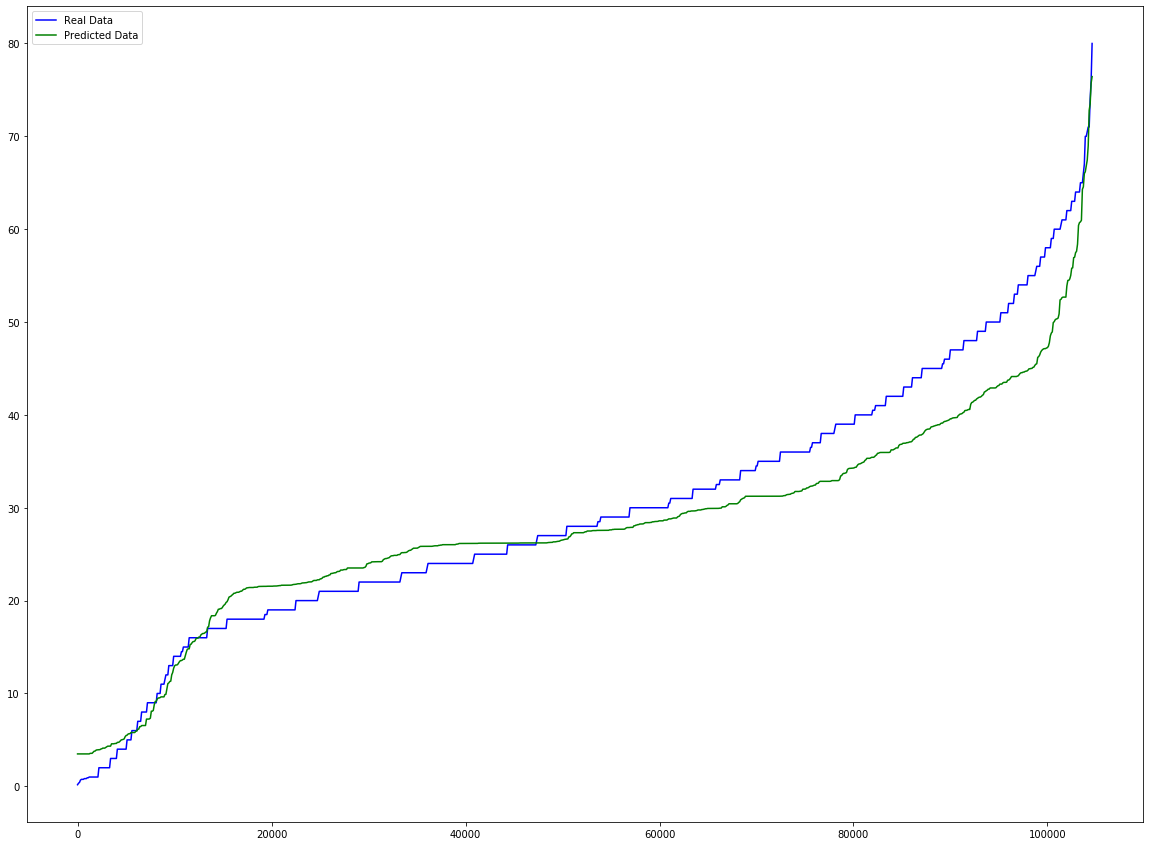

In [195]:
real_data = np.sort(targets)
predicted_data = np.sort(regressor(torch.Tensor(predictors)).detach().numpy().T[0])

fig, ax = plt.subplots()
fig.set_size_inches(20, 15)

plt.plot(np.linspace(start=0, stop=len(real_data)*100, num=len(real_data)), real_data, color='b', label='Real Data')
plt.plot(np.linspace(start=0, stop=len(real_data)*100, num=len(real_data)), predicted_data, color='g', label='Predicted Data')

plt.legend()

In [226]:
train_ages = torch.FloatTensor(StandardScaler().fit_transform(train[train['Age'] < 0][['Pclass', 'Sex', 'SibSp' ,'Parch', 'Ticket','Fare', 'Cabin', 'Embarked', 'Title']]))
train_predict = regressor(train_ages).detach().numpy()
train_predict = train_predict.reshape(len(train_predict),)
train.loc[train.Age < 0, 'Age'] = train_predict

In [227]:
test_ages = torch.FloatTensor(StandardScaler().fit_transform(test[test['Age'] < 0][['Pclass', 'Sex', 'SibSp' ,'Parch', 'Ticket','Fare', 'Cabin', 'Embarked', 'Title']]))
test_predict = regressor(test_ages).detach().numpy()
test_predict = test_predict.reshape(len(test_predict), )

test.loc[test.Age < 0, 'Age'] = test_predict


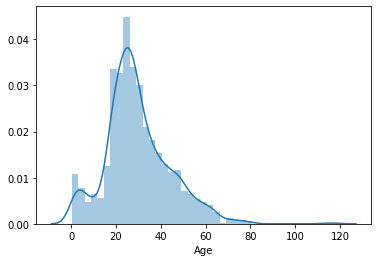

In [228]:
sns.distplot(pd.concat([train,test]).Age)

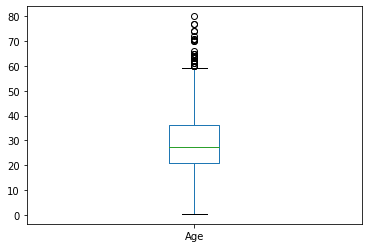

In [235]:
train.Age.plot(kind='box')

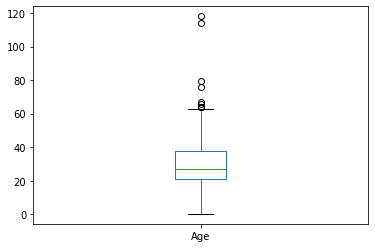

In [236]:
test.Age.plot(kind='box')

In [237]:
test.loc[test.Age > 80, 'Age'] = 80

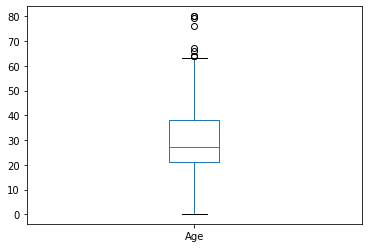

In [238]:
test.Age.plot(kind='box')

# Do final prediction

In [334]:
predictors = train.drop(['PassengerId', 'Survived', 'Embarked'], axis=1)
targets = train[['Survived']]
predictors = StandardScaler().fit_transform(predictors)

In [349]:
p_batches = torch.utils.data.DataLoader(predictors, batch_size=BATCH_SIZE, shuffle=False)
t_batches = torch.utils.data.DataLoader(targets.values.astype(float), batch_size=BATCH_SIZE, shuffle=False)

In [317]:
class NNClassifier(nn.Module):
    def __init__(self, inp_size, hidden_size):
        super().__init__()
        self.fc1 = nn.Linear(inp_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, 1)
        
    def forward(self, x):
        x = nn.functional.relu(self.fc1(x))
        x = nn.functional.sigmoid(self.fc2(x))
        return x

In [350]:
seed_everything()
classifier = NNClassifier(9, 100)
classifier

NNClassifier(
  (fc1): Linear(in_features=9, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=1, bias=True)
)

In [379]:
def train_model1(train_dl, target_dl, model, n_epochs, max_iters):
    LOG_INTERVAL = 50
    
    criteria = nn.CrossEntropyLoss()
    optim = torch.optim.Adam(regressor.parameters(), lr=0.01)
    
    acc_loss = 0
    i = 1
    for epoch in range(n_epochs):
        for x, t in zip(train_dl, target_dl):
            
            optim.zero_grad()
            
            pred = model(x.type(torch.FloatTensor))
            print(t, pred)
            loss = criteria(t, pred)
            acc_loss += loss.item()
            loss.backward()
            optim.step()
            if(i + 1) % LOG_INTERVAL == 0:
                print('epoch %d | iter %d | loss %.5f' % (epoch + 1, i + 1, acc_loss / LOG_INTERVAL), loss.item())
            
            
            i += 1
            if i == max_iters:
                return
            
train_model1(train_dl=p_batches, target_dl=t_batches, model=classifier, n_epochs=50, max_iters=1000)
pred = classifier(torch.FloatTensor(predictors))
pred = pred.detach().numpy()
pred.resize(len(pred),)
pred = pred.round()
(pred==targets).sum()/float(len(pred))
                

tensor([[0.],
        [1.],
        [1.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [1.],
        [1.],
        [1.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [1.],
        [0.],
        [1.]], dtype=torch.float64) tensor([[0.5302],
        [0.5903],
        [0.5027],
        [0.6147],
        [0.5478],
        [0.5429],
        [0.5924],
        [0.4582],
        [0.5137],
        [0.5050],
        [0.4519],
        [0.6113],
        [0.5257],
        [0.4749],
        [0.5063],
        [0.6061],
        [0.4633],
        [0.5492],
        [0.5226],
        [0.5516]], grad_fn=<SigmoidBackward>)


RuntimeError: 1D target tensor expected, multi-target not supported

0.0057361376673040155

In [59]:
mlp = MLPRegressor(batch_size=50, hidden_layer_sizes=(140))
mlp.fit(x_train, y_train)

y_pred = mlp.predict(x_train).round()
test_pred = mlp.predict(x_test).round()

score = accuracy_score(y_train, y_pred)
test_score = accuracy_score(y_test, test_pred)

mlp, score, test_score

(MLPRegressor(activation='relu', alpha=0.0001, batch_size=50, beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=140, learning_rate='constant',
              learning_rate_init=0.001, max_iter=200, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=None, shuffle=True, solver='adam', tol=0.0001,
              validation_fraction=0.1, verbose=False, warm_start=False),
 0.8797886393659181,
 0.8134328358208955)

In [60]:
test.drop(['PassengerId'], axis=1).shape, predictors.shape

((418, 9), (891, 8))

In [61]:
ids = test['PassengerId']
predictions = np.abs(mlp.predict(StandardScaler().fit_transform(test.drop(['PassengerId', 'Embarked'], axis=1))).round()).astype(int)

output = pd.DataFrame({ 'PassengerId' : ids, 'Survived': predictions })
output.to_csv('mlpsubmission.csv', index=False)